# Setup

In [1]:
if not "wdSet" in globals():
    %cd -q ..
    wdSet = True

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import pandas as pd
import numpy as np
import glob
import tqdm
import asyncio
import ccxt
from tqdm.auto import tqdm

import matplotlib as mpl
from matplotlib import pyplot as plt

from datetime import datetime, timedelta, timezone
from pprint import pprint

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']= 'True' # MacOS bug

# Data

In [5]:
exchange = ccxt.bitstamp({"enableRateLimit": True, "rateLimit": 85})

In [6]:
from core.data.cdd import get_historical_data, get_crypto_dataset

get_crypto_dataset(
    exchange,
    symbol="BTC/USD",
    timeframe="1h",
    start_date=datetime(2015, 1, 1),
    max_per_page=1000,
)

,datetime,open,high,low,close,volume
0,2015-01-01 01:00:00,314.70,315.80,314.34,315.20,23.948645
1,2015-01-01 02:00:00,315.38,317.11,315.12,315.70,91.662967
2,2015-01-01 03:00:00,315.67,316.27,314.34,316.27,33.067211
3,2015-01-01 04:00:00,316.01,318.25,315.00,316.64,286.291773
4,2015-01-01 05:00:00,316.64,317.30,314.41,315.63,178.913984
...,...,...,...,...,...,...
55066,2021-04-13 19:00:00,63225.20,63682.24,63195.42,63564.48,94.362186
55067,2021-04-13 20:00:00,63605.69,63860.71,63250.28,63348.22,93.702392
55068,2021-04-13 21:00:00,63288.05,63512.71,63133.45,63496.86,127.000117
55069,2021-04-13 22:00:00,63480.00,63494.79,63122.99,63256.37,80.725728


In [7]:
get_crypto_dataset(
    exchange,
    symbol="ETH/USD",
    timeframe="1h",
    start_date=datetime(2017, 1, 1),
    max_per_page=1000,
)

get_crypto_dataset(
    exchange,
    symbol="LTC/USD",
    timeframe="1h",
    start_date=datetime(2017, 1, 1),
    max_per_page=1000,
)

get_crypto_dataset(
    exchange,
    symbol="ETH/BTC",
    timeframe="1h",
    start_date=datetime(2017, 1, 1),
    max_per_page=1000,
)

get_crypto_dataset(
    exchange,
    symbol="LTC/BTC",
    timeframe="1h",
    start_date=datetime(2017, 1, 1),
    max_per_page=1000,
)


get_crypto_dataset(
    exchange,
    symbol="XRP/USD",
    timeframe="1h",
    start_date=datetime(2017, 1, 1),
    max_per_page=1000,
)

get_crypto_dataset(
    exchange,
    symbol="XRP/BTC",
    timeframe="1h",
    start_date=datetime(2017, 1, 1),
    max_per_page=1000,
)

,datetime,open,high,low,close,volume
0,2017-02-10 08:00:00,0.000006,0.000006,0.000006,0.000006,3000.000000
1,2017-02-10 09:00:00,0.000006,0.000006,0.000006,0.000006,991.234553
2,2017-02-10 10:00:00,0.000006,0.000006,0.000006,0.000006,0.000000
3,2017-02-10 11:00:00,0.000006,0.000006,0.000006,0.000006,0.000000
4,2017-02-10 12:00:00,0.000006,0.000006,0.000006,0.000006,0.000000
...,...,...,...,...,...,...
36558,2021-04-13 19:00:00,0.000028,0.000028,0.000027,0.000028,428131.015691
36559,2021-04-13 20:00:00,0.000028,0.000029,0.000028,0.000029,719270.896960
36560,2021-04-13 21:00:00,0.000029,0.000029,0.000028,0.000028,937370.801340
36561,2021-04-13 22:00:00,0.000028,0.000029,0.000028,0.000028,183843.543208


# Test

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [9]:
from train import load_datasets

train, val = load_datasets(["BTC/USD"], "1h", 0.15, 256)

BTC/USD 49564


In [10]:
from core.nn.lit import LitVAE

model = LitVAE.load_from_checkpoint("checkpoints/masknet-epoch=23-loss_val=0.14.ckpt")
model.eval()
model.freeze();

In [12]:
train_loader = DataLoader(train, batch_size=64, shuffle=False)
val_loader = DataLoader(val, batch_size=64, shuffle=False)

In [13]:
train_embeddings = []
val_embeddings = []

for batch in tqdm(train_loader):
    mu, log_var = model.vae.encode(batch["x"])
    vec = torch.cat((mu, log_var), dim=1)
    train_embeddings.append(vec)

for batch in tqdm(val_loader):
    mu, log_var = model.vae.encode(batch["x"])
    vec = torch.cat((mu, log_var), dim=1)
    val_embeddings.append(vec)

train_embeddings = torch.cat(train_embeddings)
val_embeddings = torch.cat(val_embeddings)

In [14]:
seq_len = 256
pred_window = 256

In [38]:
train_embeddings = train_embeddings[:-pred_window]

In [15]:
index = -1
k = 5

values, indices = torch.topk(
    torch.cdist(train_embeddings, val_embeddings[None, index], p=1)[:, 0],
    k,
    largest=False,
)

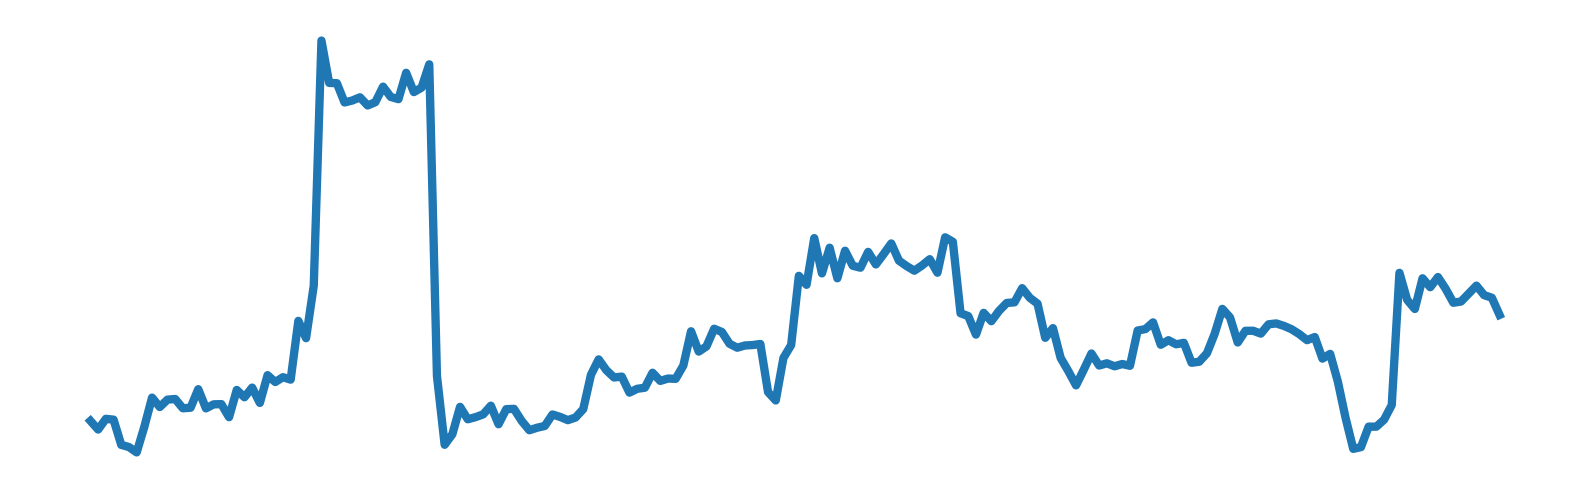

In [16]:
plt.figure(figsize=(10, 3))
plt.axis("off")
v = train.datasets[0].data.iloc[indices[0].item()+seq_len:indices[0].item()+seq_len+pred_window]["close"].values
plt.plot(v, linewidth=3)

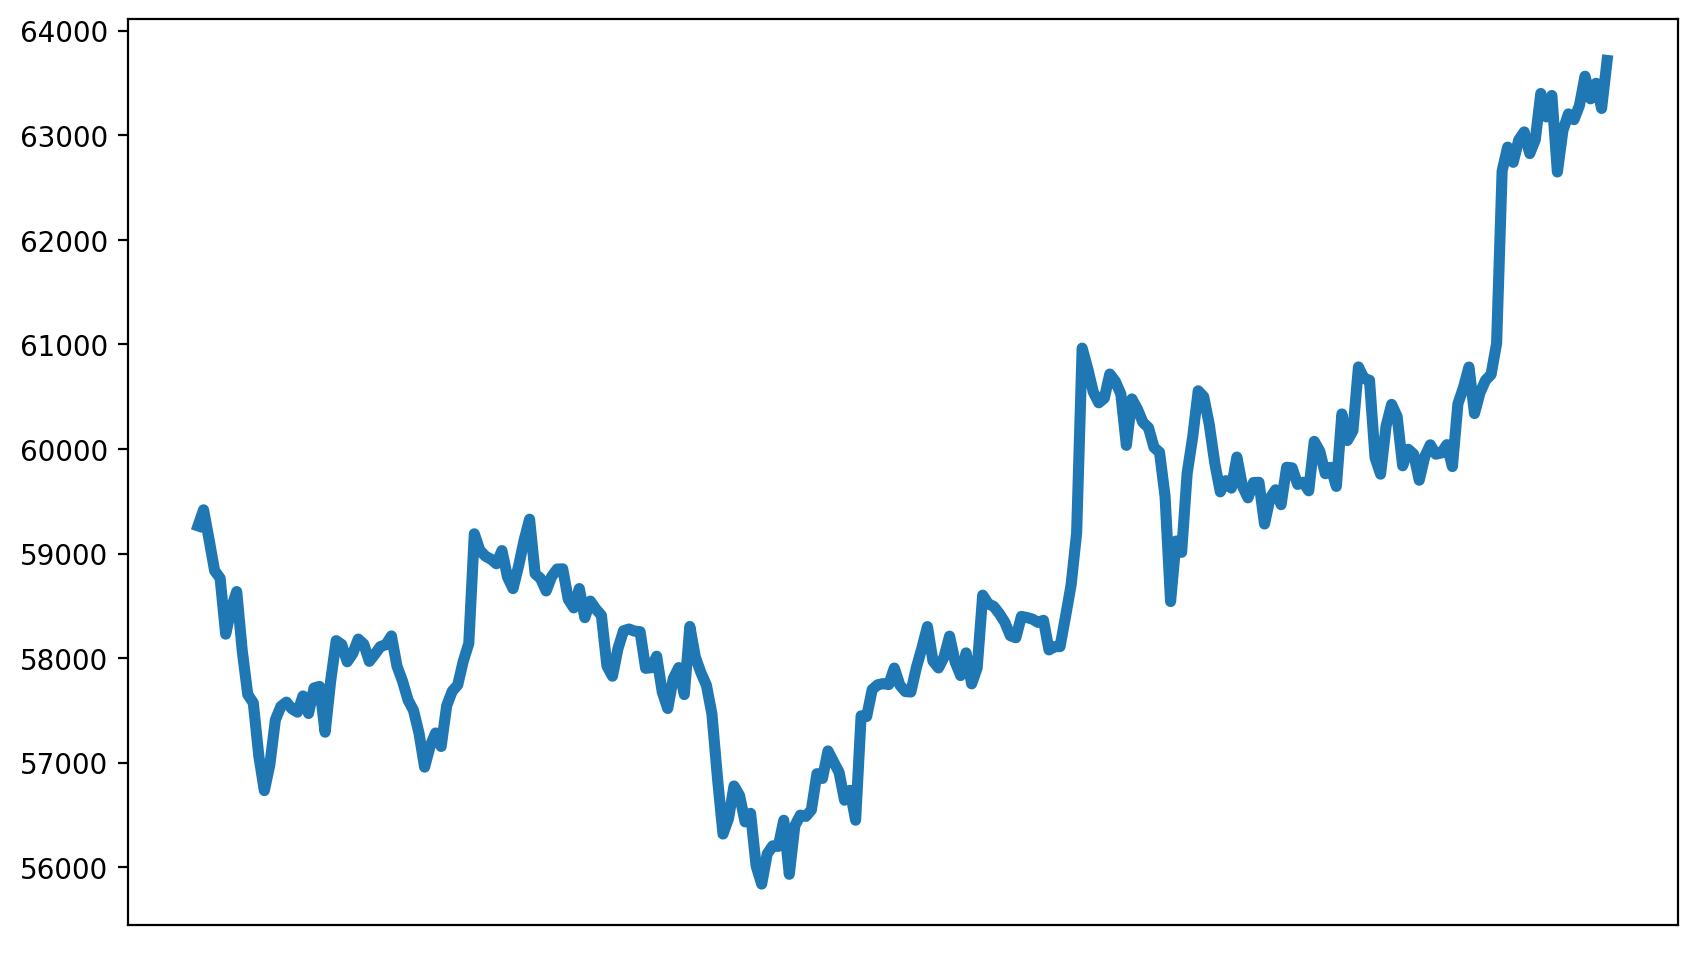

In [20]:
fig = plt.figure(figsize=(10, 6))
# v, scales, _ = train[indices[0].item()].values()
v, scales, _ = val[index].values()

plt.plot(((v[0] * scales[1])+scales[0]), linewidth=4)
fig.axes[0].get_xaxis().set_visible(False)

# plt.plot(val[index]["x"][0], linewidth=4)

In [39]:
def evaluate(seq_len, prediction_window, embed_cmp, pred_error_cmp):
    errors = []
    pred_target = []
    matches = []
    for i in range(0, len(val_embeddings) - prediction_window - 1, seq_len // 4):
        target_vec = val_embeddings[None, i]
        indices = embed_cmp(train_embeddings, target_vec)
        
        j = indices[0].item()
        d = train[j]
        m_train = d["x"][0]
        tr_scales = d["scales"]
        
        pred = train.datasets[0].data.iloc[j + seq_len : j + seq_len + prediction_window]["close"].values
        pred = (pred - tr_scales[0]) / (tr_scales[1] + 1e-8)
        
        j2 = indices[1].item()
        d2 = train[j2]
        m_train2 = d2["x"][0]
        tr_scales2 = d2["scales"]
        pred2 = train.datasets[0].data.iloc[j2 + seq_len : j2 + seq_len + prediction_window]["close"].values
        pred2 = (pred2 - tr_scales2[0]) / (tr_scales2[1] + 1e-8)
        
        l = min(len(pred), len(pred2))
        pred = (pred[:l]+pred2[:l])/2
        
        d = val[i]
        m_val = d["x"][0]
        scales = d["scales"]
        target = val.datasets[0].data.iloc[i + seq_len : i + seq_len + prediction_window]["close"].values
        target = (target - scales[0]) / (scales[1] + 1e-8)
        
        error = pred_error_cmp(pred, target)
        errors.append(error)
        pred_target.append((pred, target))
        matches.append((m_train, m_val))
    errors = np.array(errors)
    return matches, pred_target, errors, errors.mean(), errors.std()

In [40]:
cdist_w_cmp = lambda x, y: torch.topk(
    torch.cdist(x[:, :32], y[:, :32], p=1)[:, 0] + torch.cdist(x[:, 32:], y[:, 32:], p=1)[:, 0] / 2,
    5,
    largest=False,
)[1]

cdist_cmp = lambda x, y: torch.topk(
    torch.cdist(x, y, p=1)[:, 0],
    5,
    largest=False,
)[1]

cdist2_cmp = lambda x, y: torch.topk(
    torch.cdist(x, y, p=2)[:, 0],
    5,
    largest=False,
)[1]

cosine_cmp = lambda x, y: torch.topk(
    nn.CosineSimilarity()(x, y),
    5,
    largest=True,
)[1]

cosine_w_cmp = lambda x, y: torch.topk(
    nn.CosineSimilarity()(x[:, :32], y[:, :32]) + nn.CosineSimilarity()(x[:, 32:], y[:, 32:]) / 2,
    5,
    largest=True,
)[1]

In [41]:
pred_mae_cmp = lambda x, y: np.abs((x - y)).mean()

In [51]:
matches, pred_target, errors, mean, std = evaluate(256, 192, cosine_cmp, pred_mae_cmp)
mean, std

(2.7140745387002387, 2.6617188136875174)

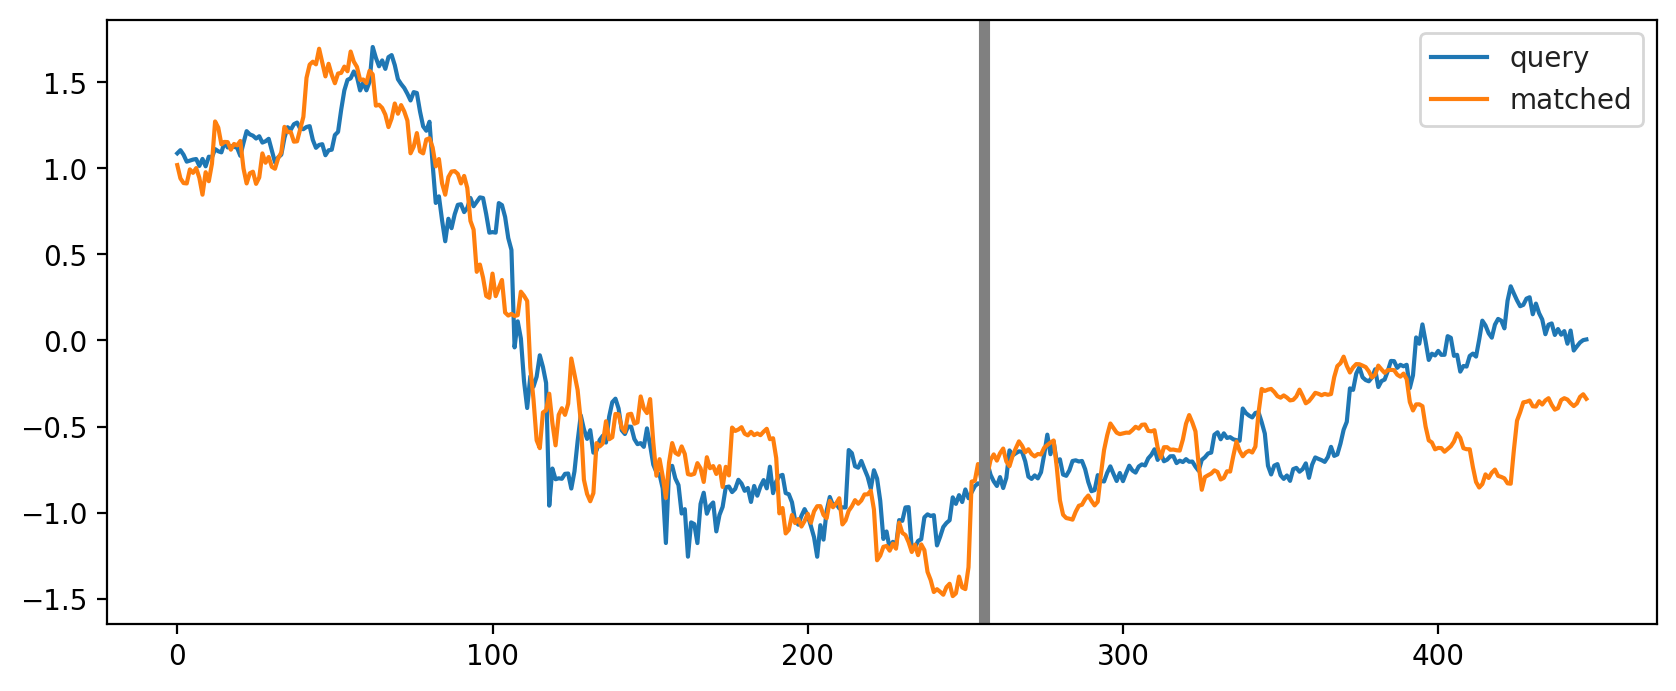

In [57]:
p_index = 31
p, t = pred_target[p_index]
p0, t0 = matches[p_index]

p = np.concatenate((p0, p))
t = np.concatenate((t0, t))

plt.figure(figsize=(10, 4))
plt.plot(t, label="query")
plt.plot(p, label="matched")
plt.axvline(x=len(p0), linewidth=4, color="gray")
plt.legend()

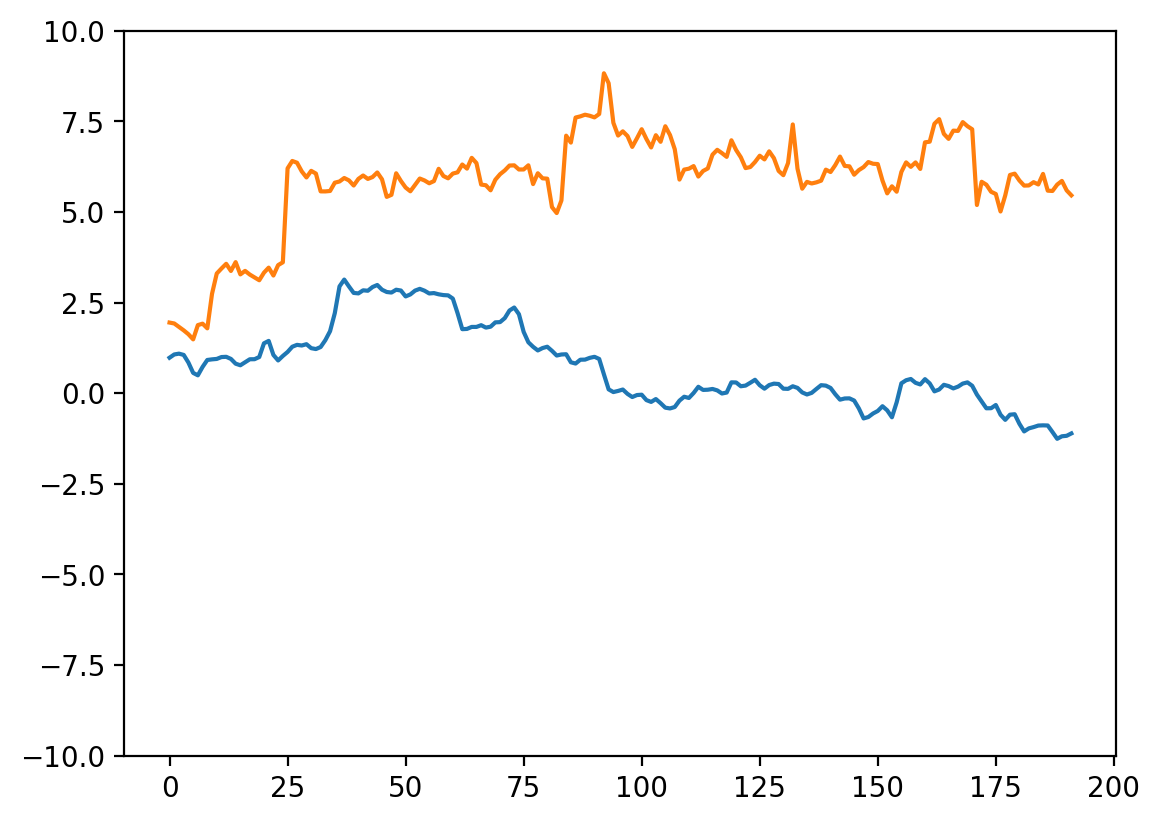

In [58]:
plt.ylim(-10, 10)
plt.plot(pred_target[42][0])
plt.plot(pred_target[42][1])